In [21]:
import pandas as pd
from torchvision import transforms
import torchvision
import torchsummary
import numpy as np
from code.diganes_dataset import DiganesDataset
from code.MyPytorchModel import MyPytorchModel
from code.permutation_transform import RandomPermutation
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from PIL import Image
import pickle
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load dataset and checkout transformation

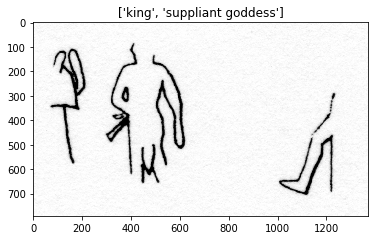

In [2]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50)

image, labels = diganes[222]
diganes.show_image(image, labels)

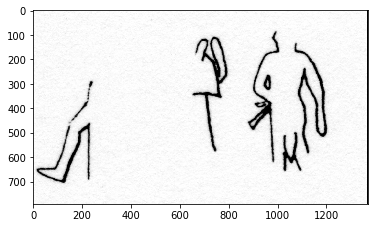

In [3]:
transform = RandomPermutation(cache_dir=pic_dir)
per = transform(image)
plt.imshow(per)

In [4]:
transform = transforms.Compose(
    [RandomPermutation(cache_dir=pic_dir),
     transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.49191375, 0.48235852, 0.44673872], 
                          std=[0.24706447, 0.24346213, 0.26147554])])

dataset = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50, transform=transform)

In [5]:
# load the pretrained model
pretrained_model = torchvision.models.mobilenet_v2(pretrained=True)

# features
print('Conv feature extractor:')
print(pretrained_model.features)
# classifier
print('Classification head:')
print(pretrained_model.classifier)

Conv feature extractor:
Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [6]:
feature_extractor = pretrained_model.features

torchsummary.summary(feature_extractor, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [16]:
# Feel free to change the hyperparameters here!
hparams = {
    "batch_size": 64,
    "lr": 3e-4
}

model = MyPytorchModel(hparams, dataset, torchvision.models.mobilenet_v2(pretrained=True))

In [17]:
trainer = None

early_stop_callback = EarlyStopping(
   monitor='val_f1',
   patience=3,
   verbose=True,
   mode='max'
)

trainer = pl.Trainer(
    max_epochs=10,
    early_stop_callback=early_stop_callback
)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

    | Name                                | Type                 | Params
-------------------------------------------------------------------------
0   | model                               | PretrainedClassifier | 2 M   
1   | model.feature_extractor             | Sequential           | 2 M   
2   | model.feature_extractor.0           | ConvBNReLU           | 928   
3   | model.feature_extractor.0.0         | Conv2d               | 864   
4   | model.feature_extractor.0.1         | BatchNorm2d          | 64    
5   | model.feature_extractor.0.2         | ReLU6                | 0     
6   | model.feature_extractor.1           | InvertedResidual     | 896   
7   | model.feature_extractor.1.conv      | Sequential           | 896   
8   | model.feature_extractor.1.conv.0    | ConvBNReLU           | 352   
9   | model.feature_extractor.1.conv.0.0  | Conv2d               | 288   
10  | model.feature_

Val-F1=0.13


Val-F1=0.11


Val-F1=0.17


Val-F1=0.20


Val-F1=0.21


Val-F1=0.23


Val-F1=0.27


Val-F1=0.25


Val-F1=0.30


Val-F1=0.30


Val-F1=0.29



1

In [ ]:
f_score, scores, labels = model.getTestF1(model.train_dataloader())
print("F-1 Score: ", f_score)

In [ ]:
print("Classification report: \n", (classification_report(labels, scores, zero_division=0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


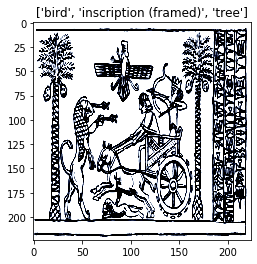

In [231]:
model.eval()
image = Image.open('test3.jpg')
image = transform(image)
X = image.reshape((1, 3, 224, 224))

score = model.forward(X)
preds = (torch.sigmoid(score).data > 0.5).float()
complete_dataset.show_image(image, preds[0])

In [133]:
torch.save(model, "mobilenet_v2_model.pt")


PicklingError: Can't pickle <class 'code.permutation_transform.RandomPermutation'>: it's not the same object as code.permutation_transform.RandomPermutation